In [1]:
import geopandas as gpd
import plot_functions as pf
import math
import numpy as np
import wandb
import pickle
import os
import shapely.wkt as wkt
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from torch_geometric.transforms import LineGraph

import gzip
import xml.etree.ElementTree as ET

import torch
import torch_geometric
from torch_geometric.data import Data

# import processing_io as pio
import sys
import os
import joblib
import json

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from shapely.geometry import Point, LineString, box
from matplotlib.colors import TwoSlopeNorm

from shapely.ops import unary_union
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch_geometric.data import Data, Batch
import torch
from torch_geometric.data import Data
# import alphashape
from matplotlib.lines import Line2D

from shapely.geometry import Polygon
import alphashape
import geopandas as gpd
from shapely.geometry import LinearRing, Polygon


highway_mapping = {
    'trunk': 0, 'trunk_link': 0, 'motorway_link': 0,
    'primary': 1, 'primary_link': 1,
    'secondary': 2, 'secondary_link': 2,
    'tertiary': 3, 'tertiary_link': 3,
    'residential': 4, 'living_street': 5,
    'pedestrian': 6, 'service': 7,
    'construction': 8, 'unclassified': 9,
    'np.nan': -1
}

districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")

geojson_file_1 = "../../data/visualisation/gdf_pop_1pm_basecase_mean.geojson"
geojson_file_2 = "../../data/visualisation/gdf_pop_1pct_basecase_mean.geojson"
paris_inside_bvd_peripherique = "../../data/paris_inside_bvd_per/referentiel-comptages-edit.shp"

# Read the GeoJSON files into GeoDataFrames
gdf_pop_1pm = gpd.read_file(geojson_file_1)
gdf_pop_1pct = gpd.read_file(geojson_file_2)

common_links = set(gdf_pop_1pm['link']).intersection(gdf_pop_1pct['link'])

# Filter the rows in both GeoDataFrames where "link" is in the common_links set
gdf_pop_1pm_filtered = gdf_pop_1pm[gdf_pop_1pm['link'].isin(common_links)]
gdf_pop_1pct_filtered = gdf_pop_1pct[gdf_pop_1pct['link'].isin(common_links)]

gdf_pop_1pm_filtered['vol_car_times_10'] = gdf_pop_1pm_filtered['vol_car'] * 10

gdf_pop_1pct_filtered['highway_mapped'] = gdf_pop_1pct_filtered['highway'].map(highway_mapping)
gdf_pop_1pm_filtered['highway_mapped'] = gdf_pop_1pm_filtered['highway'].map(highway_mapping)

# Convert to correct EPSG
gdf_pop_1pct_filtered.crs = "EPSG:2154" 
gdf_pop_1pct_filtered.to_crs("EPSG:4326", inplace=True)
gdf_pop_1pm_filtered.crs = "EPSG:2154" 
gdf_pop_1pm_filtered.to_crs("EPSG:4326", inplace=True)

# Only consider streets within Boulevard Peripherique
gdf_paris_inside_bvd_per = gpd.read_file(paris_inside_bvd_peripherique)
boundary_df = alphashape.alphashape(gdf_paris_inside_bvd_per, 435).exterior[0]
linear_ring_polygon = Polygon(boundary_df)
gdf_pop_1pct_within_boundary = gdf_pop_1pct_filtered[gdf_pop_1pct_filtered.geometry.within(linear_ring_polygon)]
gdf_pop_1pm_within_boundary = gdf_pop_1pm_filtered[gdf_pop_1pm_filtered.geometry.within(linear_ring_polygon)]

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [2]:
gdf_pop_1pct_within_boundary['vol_car'].describe()

count    23699.000000
mean        43.077295
std         83.135953
min          0.000000
25%          2.536585
50%         16.439024
75%         48.378049
max       1450.292683
Name: vol_car, dtype: float64

In [3]:
gdf_pop_1pm_within_boundary['vol_car_times_10'].describe()

count    23699.000000
mean        50.382616
std         90.344861
min          0.000000
25%          0.000000
50%         18.913043
75%         62.608696
max       1460.217391
Name: vol_car_times_10, dtype: float64

## Vergleichsanalyse

Das durchschnittliche Car Volume von 0.1% Households ist mit 50 vs. 43 ca. 17% höher als das von 1% Households. WARUM ? 
Die Standard Deviation ist mit 90 vs. 83 ebenfalls höher, wenn auch nur um ca. 9%. Dies lässt auf eine Streuung der Werte schließen.

Die untersten 25% sind immer noch 0 (im Vergleich zu 1% Households, wo dies 2.5 ist), was darauf schließen lässt, dass bei dem vorgenommenen Downsampling auf mind. 1/4 der Straßen gar kein Verkehr ist.

Die untersten 75% sind 63, höher als die eigentlichen 48 mit weniger Downsampling. Dies lässt darauf schließen, dass das Car volume, wenn es angepasst wird, hier "over shooted". 

Der größte Wert ist mit 1460 (vgl. 1450) überraschend genau. 

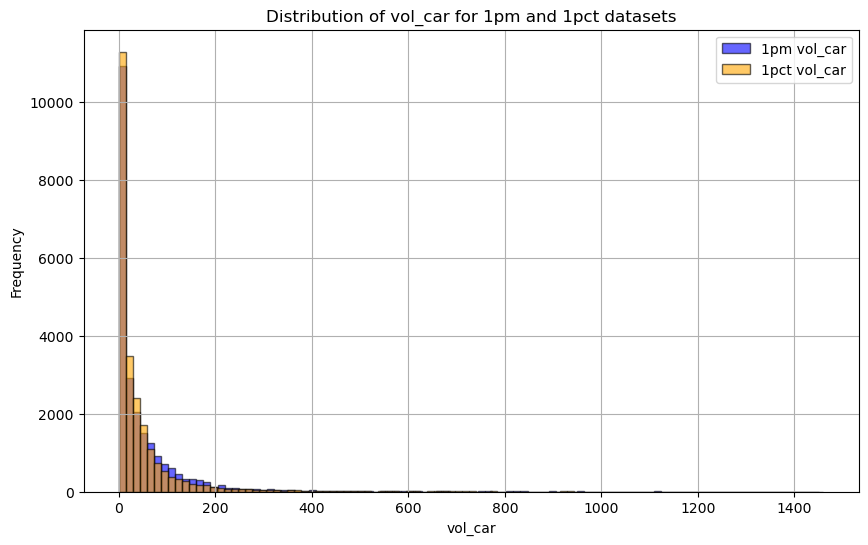

In [4]:
import matplotlib.pyplot as plt

# Assuming both GeoDataFrames are already loaded:
# gdf_pop_1pm_within_boundary and gdf_pop_1pct_within_boundary

# Extracting the 'vol_car' columns
vol_car_1pm = gdf_pop_1pm_within_boundary['vol_car_times_10']
vol_car_1pct = gdf_pop_1pct_within_boundary['vol_car']

# Plotting the distributions
plt.figure(figsize=(10, 6))

# Plot for the 1pm dataset
plt.hist(vol_car_1pm, bins=100, alpha=0.6, label='1pm vol_car', color='blue', edgecolor='black')

# Plot for the 1% dataset
plt.hist(vol_car_1pct, bins=100, alpha=0.6, label='1pct vol_car', color='orange', edgecolor='black')

# Adding titles and labels
plt.title('Distribution of vol_car for 1pm and 1pct datasets')
plt.xlabel('vol_car')
plt.ylabel('Frequency')

# Adding a legend to differentiate the datasets
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

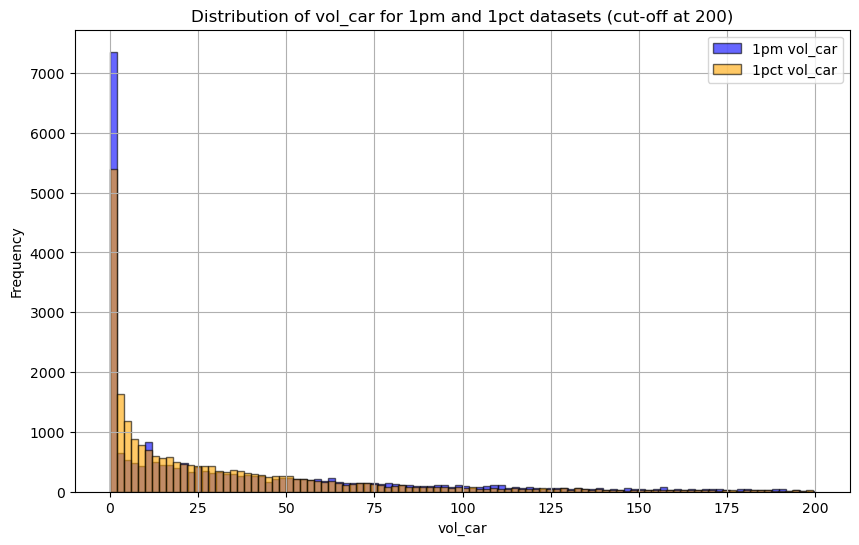

In [5]:
# I'll create the plot with a cut-off at 400 for both distributions
import matplotlib.pyplot as plt

# Plotting the distributions with a cut-off at 400
plt.figure(figsize=(10, 6))

# Plot for the 1pm dataset with a cut-off at 400
plt.hist(vol_car_1pm[vol_car_1pm <= 200], bins=100, alpha=0.6, label='1pm vol_car', color='blue', edgecolor='black')

# Plot for the 1pct dataset with a cut-off at 400
plt.hist(vol_car_1pct[vol_car_1pct <= 200], bins=100, alpha=0.6, label='1pct vol_car', color='orange', edgecolor='black')

# Adding titles and labels
plt.title('Distribution of vol_car for 1pm and 1pct datasets (cut-off at 200)')
plt.xlabel('vol_car')
plt.ylabel('Frequency')

# Adding a legend to differentiate the datasets
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

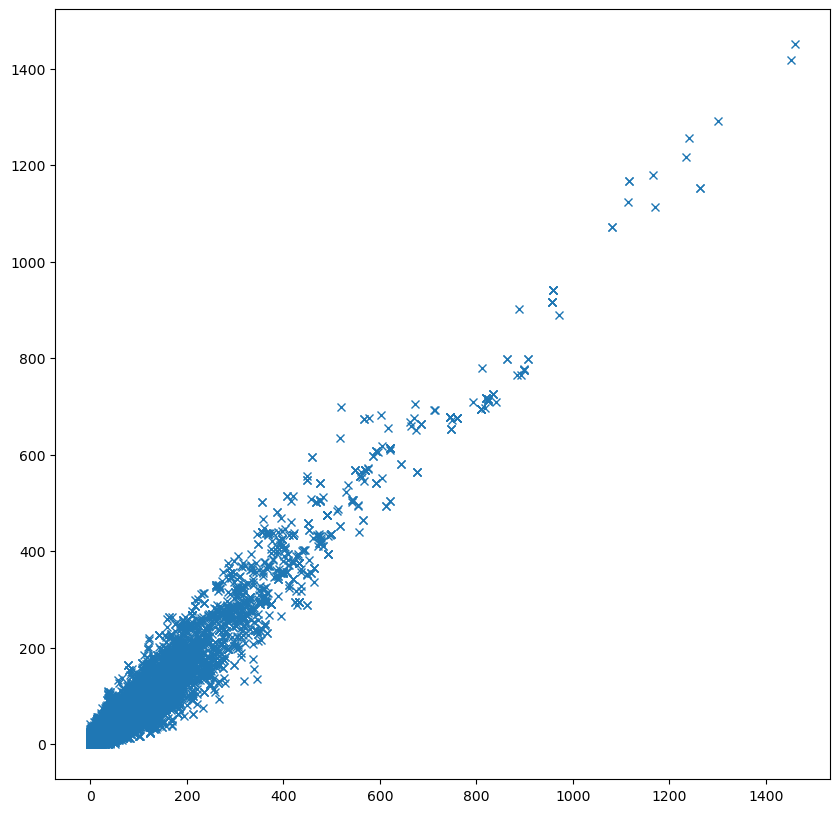

In [6]:
plt.figure(figsize=(10,10))

plt.plot(gdf_pop_1pm_within_boundary['vol_car_times_10'].values, gdf_pop_1pct_within_boundary['vol_car'].values, "x")